# Load Data

In [1]:
import random
import pandas as pd
import numpy as np
import os
import utm

import matplotlib.pyplot as plt
import plotly.express as px

import geopandas as gpd
from pyhigh import get_elevation_batch
from shapely.geometry import Point

# Modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pykrige.ok import OrdinaryKriging 



/Users/lilynorthcutt/Documents/Projects/sierraNevadaAge/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
random.seed(1)

In [3]:
# Read in CSV file
csv_file_path = "Data/raw/attia_CentralSierraCretaceousIntrusionsGeochronologyData_forLily12082023.xlsx"
df_ages_raw = pd.read_excel(csv_file_path, sheet_name =  'CentralSierraNevada Rock Ages')

In [4]:
# Read in shapefiles

def read_shapefiles_in_folder(folder_path):
    'FUNCTION TO READ IN ALL SHAPEFILES FROM A FOLDERPATH'
    shapefiles_dict = {}

    # Check if the folder path exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder '{folder_path}' does not exist.")

    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".shp"):
            file_path = os.path.join(folder_path, filename)

            # Extract file name without extension
            file_name = os.path.splitext(filename)[0]

            # Read shapefile into GeoDataFrame
            gdf = gpd.read_file(file_path)

            # Store GeoDataFrame in the dictionary
            shapefiles_dict[file_name] = gdf

    return shapefiles_dict

folder_path = 'Data/raw/CentralSierraMapData_ForLily20231220'

try:
    # Read shapefiles into a dictionary
    shapefiles_data = read_shapefiles_in_folder(folder_path)

    # Access GeoDataFrames by file name
    for file_name, gdf in shapefiles_data.items():
        print(f"File Name: {file_name}")
        #print(gdf.head())  # Display the first few rows of the GeoDataFrame

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")


File Name: CretaceousIntrusionsIndividualPolygons
File Name: CretaceousIntrusionsExtentPolygons
File Name: DetailedMapDataAreaBoundaryLine
File Name: IntrusiveSuitePolygons


# Preprocessing


## Clean/Wrangle Data

Size of cleaned csv data: 213


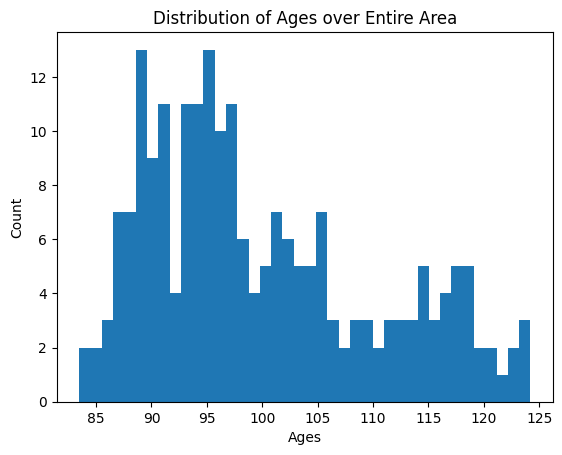

<Figure size 40x40 with 0 Axes>

In [5]:
# Clean csv
 
# ------ Handle missing values ---------
# When original name is NA, then originalName == AnalysisName
df_ages_raw['OriginalName'] = df_ages_raw['OriginalName'].fillna(df_ages_raw['AnalysisName']) 
# When easting & northing == "NA*" then convert to NA
df_ages_raw['Easting'] = pd.to_numeric(df_ages_raw['Easting'].replace('NA*', pd.NA), errors = 'coerce') 
df_ages_raw['Northing'] = pd.to_numeric(df_ages_raw['Northing'].replace('NA*', pd.NA), errors = 'coerce')
# Remove when location (easting or northing) is NA
df_ages = df_ages_raw[pd.notna(df_ages_raw['Easting']) & pd.notna(df_ages_raw['Northing'])].copy()
print("Size of cleaned csv data:", len(df_ages))

# ---------- Create POINT dataframe -----------
# Make points a POINT() geometry
# EPSG:26711
df_point = gpd.GeoDataFrame(df_ages, geometry=gpd.points_from_xy(df_ages.Easting, df_ages.Northing),  crs='epsg:26711')


##### View distrubtion of ages
plt.hist(df_ages['Age'], bins = 40)
plt.xlabel("Ages")
plt.ylabel("Count")
plt.title("Distribution of Ages over Entire Area")
plt.figure(figsize=(.5, .5), dpi=80)
plt.show()

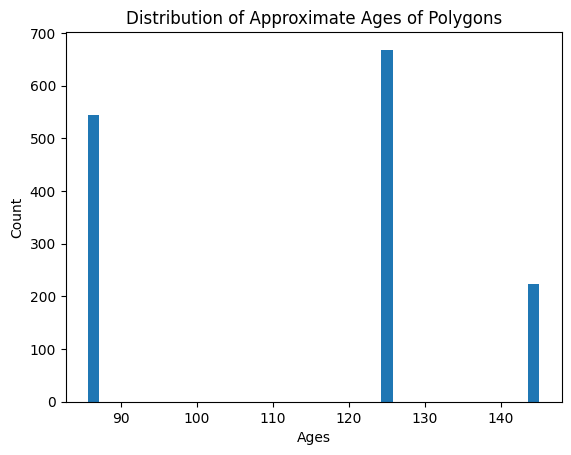

<Figure size 40x40 with 0 Axes>

In [6]:
# Clean shapefile

# ------------- Add Numeric Approx Age ---------------
#shapefiles_data["CretaceousIntrusionsIndividualPolygons"].Age.unique()
#array(['eK', 'KJ', 'lK', 'eK?', 'lK?'], dtype=object)
# PERIODS:
# J: 201.3-145.0 MYA
# K: 145.0-66.0 MYA
# Thus mapping eK to mean(145 and mean(145, 66)), lK to mean(mean(145, 66), 66) and KJ to 145
# Note that the oldest point in df_ages is 124.2
k_mean = (145+66)/2 ; eK_mean = (145+k_mean)/2; lk_mean = (k_mean+66)/2; kJ = 145;
(shapefiles_data["CretaceousIntrusionsIndividualPolygons"])["ageNum"] = shapefiles_data["CretaceousIntrusionsIndividualPolygons"].Age.apply(
    lambda x: eK_mean if (x == 'eK' or x == 'eK?') else(lk_mean if (x == 'lK' or x == 'lK?') else kJ))

##### View distrubtion of approximate ages
plt.hist((shapefiles_data["CretaceousIntrusionsIndividualPolygons"])["ageNum"], bins = 40)
plt.xlabel("Ages")
plt.ylabel("Count")
plt.title("Distribution of Approximate Ages of Polygons")
plt.figure(figsize=(.5, .5), dpi=80)
plt.show()

## Feature Engineering

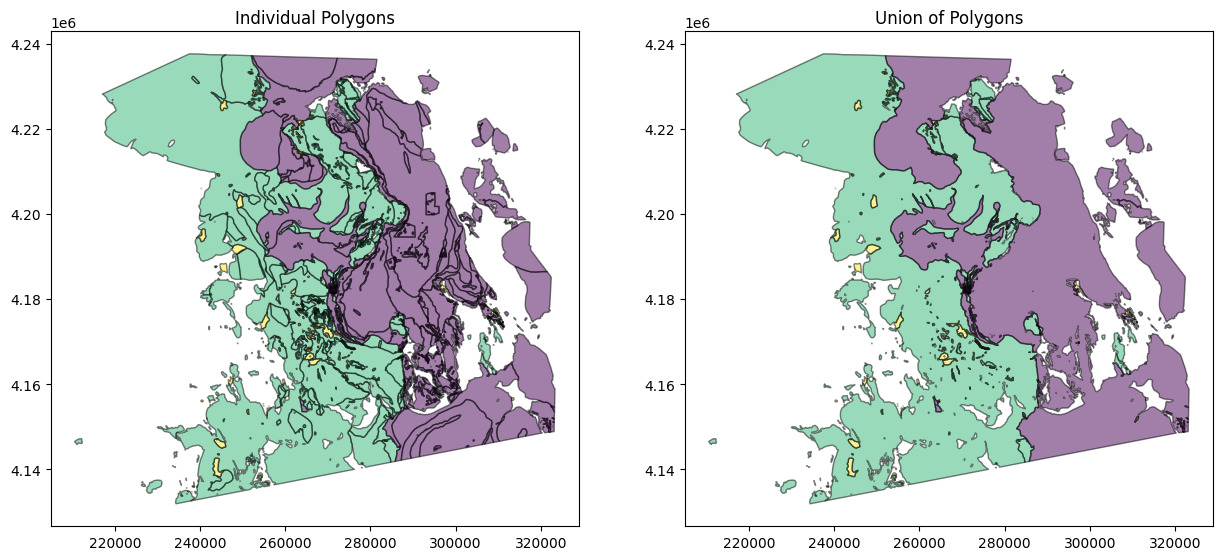

In [7]:
# Feature Engineering - Shapefile

# ---------- Combined if polygon touching and same period ----------
shapefiles_data['UnionPolygons'] = shapefiles_data["CretaceousIntrusionsIndividualPolygons"].dissolve(by = 'Age')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
legend_criteria = "ageNum"
ax[0].set_title(f'Individual Polygons')
ax[1].set_title(f'Union of Polygons')

shapefiles_data["CretaceousIntrusionsIndividualPolygons"].plot(figsize=(10, 10), alpha=0.5, edgecolor='k',column=legend_criteria, cmap='viridis', legend=False,ax=ax[0] )
shapefiles_data['UnionPolygons'].plot(figsize=(10, 10), alpha=0.5, edgecolor='k',column=legend_criteria, cmap='viridis', legend=False,ax=ax[1] )


plt.show()


In [8]:
# Feature Engineering - CSV File

# -------- Separate comment column into own columns -----
location_estim_list = ["location not given", "location is a total guess", "approximate location"]
pattern = '|'.join(location_estim_list)
df_ages['locationEstimated'] = df_ages['DataComment'].str.contains(pattern, case = False, na = False)
df_ages['uncertaintyEstimated'] = df_ages['DataComment'].str.contains('no error given', case = False, na = False)

# ---------- Lat/Lng -----------------
lat, long = utm.to_latlon(df_ages['Easting'], df_ages['Northing'], 11, 'S')
df_ages['lat'] = lat
df_ages['long'] = long

# -------------- Year data source published ----------------
df_ages['year'] = df_ages['Reference'].str.extract(r'(\d+)', expand = False).fillna(2023).astype(int)


# ----------- Categorize into 16 sections -------------
# Partition by quartiles for easting and northing
quartile_boundaries_easting = df_ages['Easting'].quantile([0, 0.25, 0.5, 0.75, 1])
quartile_boundaries_northing = df_ages['Northing'].quantile([0, 0.25, 0.5, 0.75, 1])

df_ages['easting_quartile'] = pd.cut(df_ages['Easting'], bins=quartile_boundaries_easting, labels=[1, 2, 3, 4], include_lowest = True)
df_ages['northing_quartile'] = pd.cut(df_ages['Northing'], bins=quartile_boundaries_northing, labels=[1, 2, 3, 4], include_lowest = True)

# Convert categorical characters to numeric
cat_columns = df_ages.select_dtypes(['category']).columns
df_ages[cat_columns] = df_ages[cat_columns].apply(lambda x: x.cat.codes)

# Categorize each square in 2D space of easting and northing boundaries
# such that each unique combination of easting_quartile and northing_quartile
# starting at 1, going left to right across the row, going down a row and repeating, ending at 16
df_ages["square"] = 4*(df_ages['easting_quartile']) + df_ages['northing_quartile'] + 1


In [10]:
# Feature Engineering - CSV File (continued)
#
####### GEOLOGIC FEATURES #############

# ----------- Elevation ---------------
# Sending batch is faster than individual (https://github.com/sgherbst/pyhigh#)
#### NOTE: need to change get_url_for_zip() function in env/lib/python3.9/pyhigh/elevation.py to
# def get_url_for_zip(zip_name):
#    return f'https://firmware.ardupilot.org/SRTM/North_America/{zip_name}'
# Described in issue hereL https://github.com/sgherbst/pyhigh/issues/1
coord_batch = list(zip(df_ages['lat'], df_ages['long']))
df_ages['elevation'] = get_elevation_batch(coord_batch)


# ----------- Age Limits Based on Period of Polygon --------------
# NOTE: This limits all predictions to within the border

#geometry = [Point(xy) for xy in zip(df_ages['long'], df_ages['lat'])]
#points_gdf = gpd.GeoDataFrame(df_ages, geometry=geometry, crs="EPSG:26711")
#points_gdf['period'] = None

#for idx, point in points_gdf.iterrows():
#    for _, polygon in shapefiles_data['UnionPolygons'].iterrows():
#        if point.geometry.intersects(polygon.geometry):
#            points_gdf.at[idx, 'period'] = polygon['Age']
#            break  # Stop checking once the polygon is found



In [41]:
fig = px.scatter_3d(df_ages, x='long', y='lat', z='elevation', color='Age',
                    title = "Age Distribution with Elevation")
fig.update_layout(scene_zaxis_type="log")
fig.show()



## Prep data for modeling

### Test / Train Splits

In [24]:
# Split data into test and train + cross validation

# ----------- Traditional Split -----------------
# Use if spatial autocorrelation is not significant concern
train_trad, test_trad = train_test_split(df_ages, test_size=0.2, random_state=42)

# ----------- Spatial K-Fold CV -----------------
# Ensures spatially close points are either in training or testing (not both)
coordinates = df_ages[['lat', 'long']].values
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(coordinates):
        train_kf, test_kf = df_ages.iloc[train_index], df_ages.iloc[test_index]

# ----------- Cluster-Based Split ---------------
# Cluster data points and then split each cluster into test/train
kmeans = KMeans(n_clusters=10, random_state=42)
df_ages['cluster'] = kmeans.fit_predict(df_ages[['lat', 'long']])

train_clust, test_clust = train_test_split(df_ages, test_size=0.2, stratify=df_ages['cluster'], random_state=42)

# ------------- Spatial Blocking ----------------
# Dividing area into blocks and then split each block into test/train
# Maybe not enough points spread out for this, omitting for now
#df_point['block'] = df_point['geometry'].apply(lambda point: (int(point.x//1), int(point.y//1)))
#train_df, test_df = train_test_split(gdf, test_size=0.2, stratify=df_point['block'], random_state=42)


#

In [25]:
splits = [
    {'name': 'Traditional','train': train_trad, 'test': test_trad},
    {"name": "Spatial K-Fold",'train': train_kf, 'test': test_kf},
    {"name":"Cluster-Based", 'train': train_clust, 'test': test_clust}
]


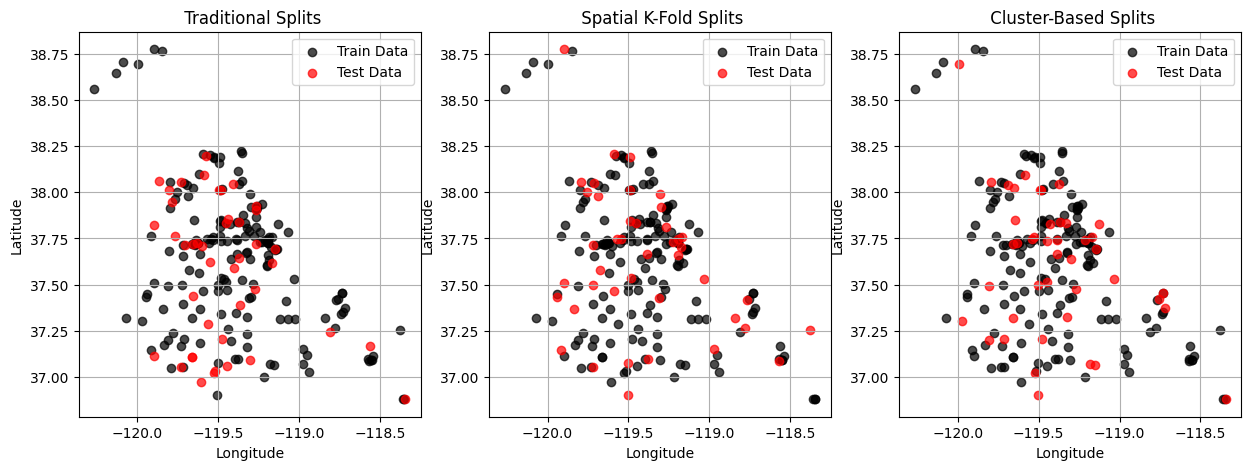

In [26]:
# View difference in test/train split for each method
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i, ax in enumerate(ax.flat):
    name = splits[i]['name']
    train_df = splits[i]['train']
    test_df = splits[i]['test']
    
    ax.scatter(train_df['long'], train_df['lat'], color='black', label='Train Data', alpha=0.7)
    ax.scatter(test_df['long'], test_df['lat'], color='red', label='Test Data', alpha=0.7)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f' {name} Splits')
    ax.grid(True)
    ax.legend()
    

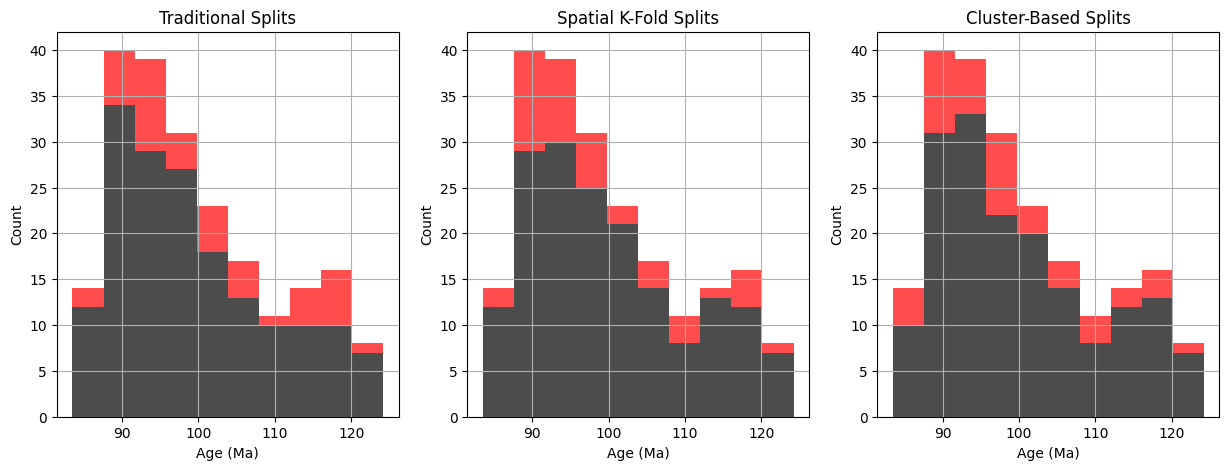

In [27]:
# View distribution of ages in test/train partitions for each method
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i, ax in enumerate(ax.flat):
    name = splits[i]['name']
    train_df = splits[i]['train']
    test_df = splits[i]['test']
    
    ax.hist([train_df['Age'], test_df['Age']], bins=10, color=['black', 'red'], label=['Train Data', 'Test Data'], alpha=0.7, stacked=True)
    ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Count')
    ax.set_title(f'{name} Splits')
    ax.grid(True)



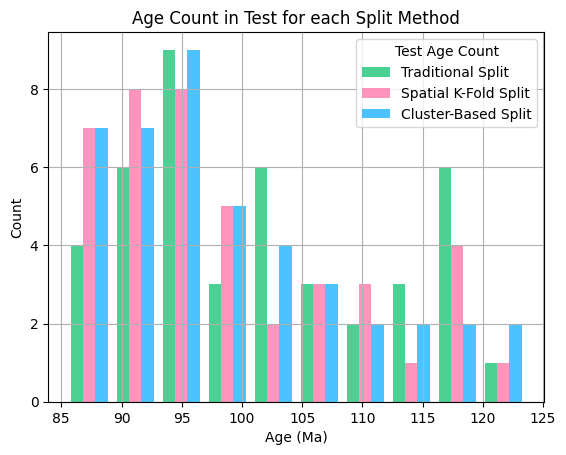

In [28]:
plt.hist([test_trad['Age'], test_kf['Age'], test_clust['Age']], bins=10, color=['#00BE67', '#FF68A1', '#00A9FF'], label=['Traditional Split', 'Spatial K-Fold Split', 'Cluster-Based Split'], alpha=0.7, stacked=False)
plt.xlabel('Age (Ma)')
plt.ylabel('Count')
plt.title(f'Age Count in Test for each Split Method')
plt.grid(True)
plt.legend( title='Test Age Count', loc='upper right')

plt.show()

### Add Features from ONLY train


In [ ]:
def nthNearest(n, lat, long, df_ref):
    # n: the nth number in the list of points sorted by how far away
    # lat and long are from point we are labeling
    # df_ref is our reference dataframe (df_train)
    
    # sort the other 
    
    
    # return 

# Model and Evaluate

## Geostat Models

Mean Absolute Error (MAE): 8.305331053351109
Root Mean Squared Error (RMSE): 9.955379432637463
Root Mean Squared Error (R2 Score): -0.004511144403303247


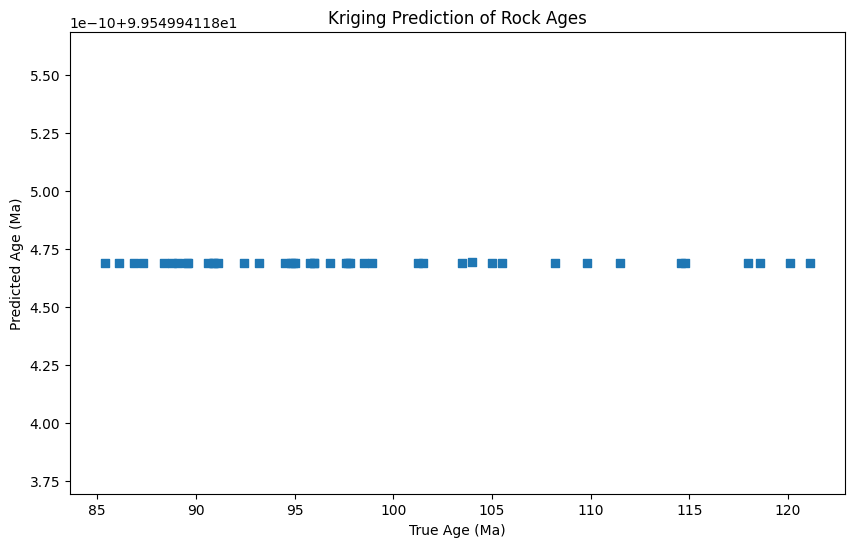

In [29]:
# ----------------- Kriging -------------------
# Extract training data
train_lat = train_trad['lat'].values
train_lon = train_trad['long'].values
train_age = train_trad['Age'].values

# Train model
kriging_model = OrdinaryKriging(
    train_lon, train_lat, train_age,
    variogram_model='linear',
    verbose=False,
    enable_plotting=False
)

# Predict the ages of the test data
test_lat = test_trad['lat'].values
test_lon = test_trad['long'].values
test_ages = test_df['Age'].values

predicted_ages, ss = kriging_model.execute('points', test_lon, test_lat)

# Evaluate the predictions
mae = mean_absolute_error(test_ages, predicted_ages)
rmse = np.sqrt(mean_squared_error(test_ages, predicted_ages))
r2 = r2_score(test_ages, predicted_ages)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Root Mean Squared Error (R2 Score): {r2}")


# Plot Results
plt.figure(figsize=(10, 6))
plt.scatter(test_ages, predicted_ages, label='Predicted Ages', marker='s')
plt.xlabel('True Age (Ma)')
plt.ylabel('Predicted Age (Ma)')
plt.title('Kriging Prediction of Rock Ages')

plt.show()


In [30]:
# -------- Inverse Distance Weighting ---------
predicted_ages




masked_array(data=[99.54994117646903, 99.54994117646902,
                   99.54994117646906, 99.54994117646918,
                   99.54994117646905, 99.54994117646912,
                   99.54994117646905, 99.54994117646908,
                   99.54994117646908, 99.54994117646905, 99.549941176469,
                   99.549941176469, 99.549941176469, 99.5499411764691,
                   99.54994117646903, 99.54994117646913,
                   99.54994117646906, 99.54994117646919,
                   99.54994117646905, 99.54994117646912,
                   99.54994117646915, 99.54994117646908,
                   99.54994117646909, 99.54994117646918,
                   99.54994117646905, 99.54994117646905,
                   99.54994117646905, 99.5499411764691, 99.549941176469,
                   99.54994117646908, 99.54994117646902,
                   99.54994117646898, 99.54994117646905,
                   99.54994117646918, 99.54994117646898, 99.5499411764691,
                   99.5

## Traditional ML

In [31]:
# ---------------- MLR ------------------


In [32]:
# ---------------- SVM ------------------


In [33]:
# ------- Polynomial Regression ---------


In [34]:
# ----------- Random Forest -------------


In [35]:
# ---------------- GBM ------------------
# (XGBOOST

## Mixed model
Using Kriging to interpolate initial values and then refine predictions using machine learning models.


In [36]:
# ------------ Kriging + ML -----------------



# Evaluate

# Predict New


In [37]:
# Create a mesh grid for predictions
min_lat, max_lat = train_trad['lat'].min(), train_trad['lat'].max()
min_lon, max_lon = train_trad['long'].min(), train_trad['long'].max()

grid_lat, grid_lon = np.mgrid[min_lat:max_lat:100j, min_lon:max_lon:100j]